In [1]:
%load_ext autoreload
%autoreload 1
%aimport connected_graphs

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

from connected_graphs import *
from structured_transitions import Randfn, SimpleMLP

import matplotlib.pyplot as plt
import copy

Transitions in will be seeded using a normally distributed vector in $R^n$. This seed will determine both the masks (if it's dynamic) as well as the initial state.

In [2]:
class StaticDataGenerator():
  def __init__(self, state_size=8, action_size=2, seed_size=4):
    """base_masks = 1 means the mask is static, higher means dynamic"""
    self.state_size = state_size
    self.action_size = action_size
    self.seed_size = seed_size
    
    self.mask = torch.randint(0, 2, (10, 8))
    self.num_inputs = self.mask.sum(0)
    self.fns = []
    for inputs in self.num_inputs:
      self.fns.append(Randfn(inputs, 1))  
    
    self._seed_to_sa = Randfn(seed_size, state_size+action_size)

  def generate(self, num_samples, noise = True):
    seed = torch.randn(num_samples, self.seed_size) # seed represents history
    sa   = self._seed_to_sa(seed)                   # sa represents the state-action
    ns   = []                                       # ns represents the next state
    
    for i, (m, fn) in enumerate(zip(self.mask.T, self.fns)):
      ns.append(fn(sa[:,torch.where(m)[0]]).squeeze()) # map relevant inputs to 1 component at a time
      if noise:
        ns[-1] += torch.randn_like(ns[-1]) * 0.5 * torch.std(ns[-1]) # add noise (for training set)
    ns   = torch.stack(ns, 1)
    return sa, ns

In [3]:
s = StaticDataGenerator()

In [4]:
xtr, ytr  = s.generate(200)
xte, yte  = s.generate(200, noise=False) # test on ground truth rather than noisy data to reduce variance

In [5]:
network = SimpleMLP((10, 256, 256, 8))

In [6]:
net = copy.deepcopy(network)
opt = torch.optim.Adam(net.parameters())

In [7]:
ltrs, ltes = [], []
for epoch in range(3000):
  with torch.no_grad():
    pte = net(xte)
    lte = F.mse_loss(pte, yte)
    ltes.append(lte.item())
    
  ptr = net(xtr.detach())
  ltr = F.mse_loss(ptr, ytr.detach())
  ltr.backward()
  opt.step()
  opt.zero_grad()
  
  ltrs.append(ltr.item())

In [8]:
ltrs1, ltes1 = copy.deepcopy(ltrs), copy.deepcopy(ltes)

(0.0, 0.0005)

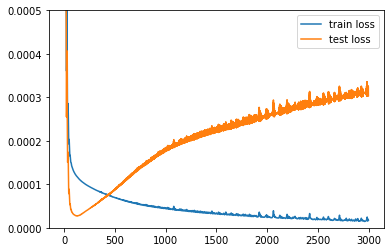

In [9]:
plt.plot(ltrs, label = 'train loss')
plt.plot(ltes, label = 'test loss')
plt.legend()
plt.ylim(0, 0.0005)

In [10]:
net = copy.deepcopy(network)
opt = torch.optim.Adam(net.parameters())

In [11]:
gt_mask = s.mask[None].repeat((len(xtr), 1, 1))

In [12]:
ltrs, ltes = [], []
gt_mask = s.mask[None].repeat((len(xtr), 1, 1))

for epoch in range(3000):
  with torch.no_grad():
    pte = net(xte)
    lte = F.mse_loss(pte, yte)
    ltes.append(lte.item())
  
  perturbation_mask = (torch.rand_like(xtr) < 0.2).to(torch.float32)
  xtr_ = xtr + perturbation_mask*torch.randn_like(perturbation_mask)*0.3 # perturb the inputs randomly

  ptr = net(xtr_.detach()) # run network on perturbed inputs
  
  unperturbed = (1. - perturbation_mask)[:, :, None]
  loss_mask = torch.all(torch.greater_equal(unperturbed, gt_mask), 1).to(torch.float32)

  ltr = ((ptr - ytr.detach())**2 * loss_mask).mean() # mask out inaccurate losses
  
  ltr.backward()
  opt.step()
  opt.zero_grad()
  
  ltrs.append(ltr.item())

In [13]:
ltrs2, ltes2 = copy.deepcopy(ltrs), copy.deepcopy(ltes)

(0.0, 0.0005)

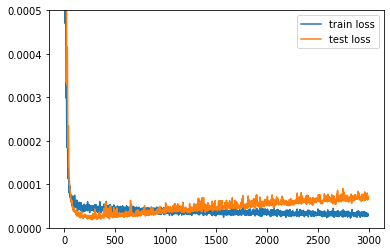

In [14]:
plt.plot(ltrs, label = 'train loss')
plt.plot(ltes, label = 'test loss')
plt.legend()
plt.ylim(0, 0.0005)

In [15]:
net = copy.deepcopy(network)
opt = torch.optim.Adam(net.parameters())

In [16]:
gt_mask = s.mask[None].repeat((len(xtr), 1, 1))

In [17]:
ltrs, ltes = [], []
gt_mask = s.mask[None].repeat((len(xtr), 1, 1))

for epoch in range(3000):
  with torch.no_grad():
    pte = net(xte)
    lte = F.mse_loss(pte, yte)
    ltes.append(lte.item())
  
  perturbation_mask = (torch.rand_like(xtr) < 0.1).to(torch.float32)
  xtr_ = xtr # DO NOT perturb the inputs randomly

  ptr = net(xtr_.detach()) # run network on perturbed inputs
  
  unperturbed = (1. - perturbation_mask)[:, :, None]
  loss_mask = torch.all(torch.greater_equal(unperturbed, gt_mask), 1).to(torch.float32)

  ltr = ((ptr - ytr.detach())**2 * loss_mask).mean() # mask out inaccurate losses
  
  ltr.backward()
  opt.step()
  opt.zero_grad()
  
  ltrs.append(ltr.item())

In [18]:
ltrs3, ltes3 = copy.deepcopy(ltrs), copy.deepcopy(ltes)

(0.0, 0.0005)

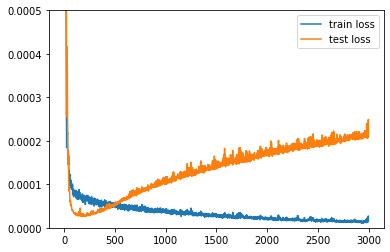

In [19]:
plt.plot(ltrs, label = 'train loss')
plt.plot(ltes, label = 'test loss')
plt.legend()
plt.ylim(0, 0.0005)

(0.0, 0.00035)

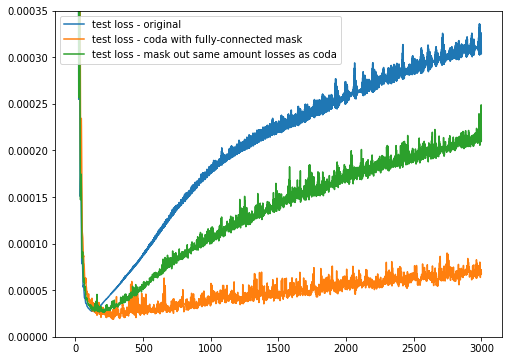

In [26]:
plt.figure(figsize=(8,6))
plt.plot(ltes1, label = 'test loss - original')
plt.plot(ltes2, label = 'test loss - coda with fully-connected mask')
plt.plot(ltes3, label = 'test loss - mask out same amount losses as coda')
plt.legend()
plt.ylim(0, 0.00035)